## Introduction

RECS is a periodic survey sponsored by the U.S. Energy Information Administration (EIA) that provides detailed information about energy usage in U.S. homes. 

Data source: [RECS Survey data](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata)

Our goal in this analysis is to build a model that predicts energy consumption in `KWH`. 

Our analysis will also go beyond getting the best possible predictions. We will focus on gaining insights that can then be used by analysts and decision makers in order to help them meet future energy demand and improve efficiency as well as building design.

We will answer the following questions using data visualization and the [SHAP library](https://github.com/slundberg/shap): 
1. Which columns in the dataset were the most important for our predictions? 
2. How are they related to the dependent variable? 
3. How do they interact with each other? 
4. Which particular features were most important for a particular observation?

Finally, we will decide which model to use based on the following: 
- Capacity to answer the above questions
- Performance
- Ease of implementation

The models we will use are:
- Random forest
- XGBoost
- Neural network using entity embeddings of categorical variables

## Methodology

Ensembles of decision trees (Random Forests & gradient boosting) are always a good first approach for analysing a new tabular dataset.

That is because interpreting a model of tabular data is very easy for decision tree ensembles thanks to the many tools and methods that exist for answering pertinent questions such as the ones mentioned above. 

After assessing the data by looking at it and understanding the feature descriptions provided, we will proceed with the following:

**1. Quick cleaning and modeling to prioritize which features to focus on first**

When dealing with a dataset with many columns (over 900 in our case), we quickly need to understand which ones are important and which ones we can discard. We'll build a tree based model with minimal feature engineering and use tools to help us understand which features are the most important. This allows us to concentrate our efforts on only the most important features instead of spending time looking at features with little to no predictive power.

**2. Increase our understanding of the data with EDA**

Once we've filtered our columns, we'll look at the ones with the highest importance. The findings in this analysis will guide our feature engineering efforts in the next section. Some questions we'll want to answer:

1. How are the top features related to our target variable?
2. What are their distributions like if we plot them with histograms and countplots?
3. What's their relationship with other important features? Do they seem to be related?
4. Are there any features that we can split into multiple columns or simplify in any way?

**3. Feature engineering.**

We can now start creating new columns by splitting up current ones, transforming them to change their scale or looking at their mean, combining new ones to create interactions, and much more.

**4. Train different models, fit them to the training data with cross validation, and perform model stacking and/or blending if needed.**

The models I intend to test are RandomForests, XGBoost, and a neural network that uses entity embeddings. 



In [71]:
%load_ext autoreload
%autoreload 2

## Imports

In [79]:
import feather
import pickle
import os
import math
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from utils import *

In [ ]:
from fastai.basics import *
from fastai.tabular import *

In [74]:
PATH = "data/raw/"

In [75]:
# Load datasets
df_layout = pd.read_csv(f'{PATH}public_layout.csv')
df_public = pd.read_csv(f'{PATH}recs2009_public.csv', low_memory=False)
df_codebook = pd.read_excel(f'{PATH}recs2009_public_codebook.xlsx', usecols='A:D')

In [76]:
# Replace '\n' with a comma to clean the df_codebook
df_codebook = df_codebook.replace('\n', ', ', regex=True)

It is important to look at our data directly to make sure we understand what type of value it holds. 

In [5]:
# Helper function to visualize all the data
display_all(df_public)

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,METROMICRO,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,BASEHEAT,BASEHT2,PCTBSTHT,BASECOOL,BASECL2,PCTBSTCL,BASEUSE,ATTIC,ATTICFIN,FINATTRMS,ATTCHEAT,ATTCHT2,PCTATTHT,ATTCCOOL,ATTCCL2,PCTATTCL,ATTICUSE,PRKGPLC1,SIZEOFGARAGE,GARGLOC,GARGHEAT,GARGCOOL,PRKGPLC2,SIZEOFDETACH,OUTLET,ZKOWNRENT,ZCONDCOOP,ZYEARMADE,ZYEARMADERANGE,ZOCCUPYYRANGE,ZCONVERSION,ZORIG1FAM,ZLOOKLIKE,ZNUMFLRS,ZNUMAPTS,ZWALLTYPE,ZROOFTYPE,ZSTUDIO,ZNAPTFLRS,ZSTORIES,ZTYPEHUQ4,ZBEDROOMS,ZNCOMBATH,ZNHAFBATH,ZOTHROOMS,ZCELLAR,ZCRAWL,ZCONCRETE,ZBASEFIN,ZFINBASERMS,ZBASEHEAT,ZBASEHT2,ZPCTBSTHT,ZBASECOOL,ZBASECL2,ZPCTBSTCL,ZBASEUSE,ZATTIC,ZATTICFIN,ZFINATTRMS,ZATTCHEAT,ZATTCHT2,ZPCTATTHT,ZATTCCOOL,ZPCTATTCL,ZATTCCL2,ZATTICUSE,ZPRKGPLC1,ZSIZEOFGARAGE,ZGARGLOC,ZGARGHEAT,ZGARGCOOL,ZPRKGPLC2,ZSIZEOFDETACH,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,OVENUSE,OVENCLN,TYPECLN,MICRO,AMTMICRO,DEFROST,OUTGRILL,OUTGRILLFUEL,TOPGRILL,STGRILA,TOASTER,NUMMEAL,FUELFOOD,COFFEE,NUMFRIG,TYPERFR1,SIZRFRI1,REFRIGT1,ICE,AGERFRI1,ESFRIG,REPLCFRI,HELPFRI,HELPFRIY,TYPERFR2,SIZRFRI2,REFRIGT2,MONRFRI2,AGERFRI2,ESFRIG2,TYPERFR3,SIZRFRI3,REFRIGT3,MONRFRI3,AGERFRI3,ESFRIG3,SEPFREEZ,NUMFREEZ,UPRTFRZR,SIZFREEZ,FREEZER,AGEFRZR,REPLCFRZ,HELPFRZ,HELPFRZY,UPRTFRZR2,SIZFREEZ2,FREEZER2,AGEFRZR2,DISHWASH,DWASHUSE,AGEDW,ESDISHW,REPLCDW,HELPDW,HELPDWY,ZSTOVEN,ZSTOVENFUEL,ZSTOVE,ZSTOVEFUEL,ZOVEN,ZOVENFUEL,ZOVENUSE,ZOVENCLN,ZTYPECLN,ZMICRO,ZAMTMICRO,ZDEFROST,ZOUTGRILL,ZOUTGRILLFUEL,ZTOPGRILL,ZSTGRILA,ZTOASTER,ZNUMMEAL,ZFUELFOOD,ZCOFFEE,ZNUMFRIG,ZTYPERFR1,ZSIZRFRI1,ZREFRIGT1,ZICE,ZAGERFRI1,ZTYPERFR2,ZSIZRFRI2,ZREFRIGT2,ZMONRFRI2,ZAGERFRI2,ZTYPERFR3,ZSIZRFRI3,ZREFRIGT3,ZMONRFRI3,ZAGERFRI3,ZSEPFREEZ,ZNUMFREEZ,ZUPRTFRZR,ZSIZFREEZ,ZFREEZER,ZAGEFRZR,ZUPRTFRZR2,ZSIZFREEZ2,ZFREEZER2,ZAGEFRZR2,ZDISHWASH,ZDWASHUSE,ZAGEDW,CWASHER,TOPFRONT,WASHLOAD,WASHTEMP,RNSETEMP,AGECWASH,ESCWASH,REPLCCW,HELPCW,HELPCWY,DRYER,DRYRFUEL,DRYRUSE,AGECDRYER,TVCOLOR,TVSIZE1,TVTYPE1,CABLESAT1,COMBODVR1,DVR1,DIGITSTB1,PLAYSTA1,COMBOVCRDVD1,VCR1,DVD1,TVAUDIOSYS1,OTHERSTB1,TVONWD1,TVONWDWATCH1,TVONWE1,TVONWEWATCH1,TVSIZE2,TVTYPE2,CABLESAT2,COMBODVR2,DVR2,DIGITSTB2,PLAYSTA2,COMBOVCRDVD2,VCR2,DVD2,TVAUDIOSYS2,OTHERSTB2,TVONWD2,TVONWDWATCH2,TVONWE2,TVONWEWATCH2,TVSIZE3,TVTYPE3,CABLESAT3,COMBODVR3,DVR3,DIGITSTB3,PLAYSTA3,COMBOVCRDVD3,VCR3,DVD3,TVAUDIOSYS3,OTHERSTB3,TVONWD3,TVONWDWATCH3,TVONWE3,TVONWEWATCH3,COMPUTER,NUMPC,PCTYPE1,MONITOR1,TIMEON1,PCONOFF1,PCSLEEP1,PCTYPE2,MONITOR2,TIMEON2,PCONOFF2,PCSLEEP2,PCTYPE3,MONITOR3,TIMEON3,PCONOFF3,PCSLEEP3,INTERNET,INDIALUP,INDSL,INCABLE,INSATEL,INWIRELESS,PCPRINT,FAX,COPIER,WELLPUMP,DIPSTICK,SWAMPCOL,AQUARIUM,STEREO,NOCORD,ANSMACH,BATTOOLS,BATCHRG,CHRGPLGT,ELECDEV,ELECCHRG,CHRGPLGE,ZCWASHER,ZTOPFRONT,ZWASHLOAD,ZWASHTEMP,ZRNSETEMP,ZAGECWASH,ZDRYER,ZDRYRFUEL,ZDRYRUSE,ZAGECDRYER,ZTVCOLOR,ZTVSIZE1,ZTVTYPE1,ZCABLESAT1,ZCOMBODVR1,ZDVR1,ZDIGITSTB1,ZPLAYSTA1,ZCOMBOVCRDVD1,ZVCR1,ZDVD1,ZTVAUDIOSYS1,ZOTHERSTB1,ZTVONWD1,ZTVONWDWATCH1,ZTVONWE1,ZTVONWEWATCH1,ZTVSIZE2,ZTVTYPE2,ZCABLESAT2,ZCOMBODVR2,ZDVR2,ZDIGITSTB2,ZPLAYSTA2,ZCOMBOVCRDVD2,ZVCR2,ZDVD2,ZTVAUDIOSYS2,ZOTHERSTB2,ZTVONWD2,ZTVONWDWATCH2,ZTVONWE2,ZTVONWEWATCH2,ZTVSIZE3,ZTVTYPE3,ZCABLESAT3,ZCOMBODVR3,ZDVR3,ZDIGITSTB3,ZPLAYSTA3,ZCOMBOVCRDVD3,ZVCR3,ZDVD3,ZTVAUDIOSYS3,ZOTHERSTB3,ZTVONWD3,ZTVONWDWATCH3,ZTVONWE3,ZTVONWEWATCH3,ZCOMPUTER,ZNUMPC,ZPCTYPE1,ZMONITOR1,ZTIMEON1,ZPCONOFF1,ZPCSLEEP1,ZPCTYPE2,ZMONITOR2,ZTIMEON2,ZPCONOFF2,ZPCSLEEP2,ZPCTYPE3,ZMONITOR3,ZTIMEON3,ZPCONOFF3,ZPCSLEEP3,ZINTERNET,ZINDIALUP,ZINDSL,ZINCABLE,ZINSATEL,ZINWIRELESS,ZPCPRINT,ZFAX,ZCOPIER,ZWELLPUMP,ZDIPSTICK,ZSWAMPCOL,ZAQUARIUM,ZSTEREO,ZNOCORD,ZANSMACH,ZBATTOOLS,ZBATCHRG,ZCHRGPLGT,ZELECDEV,ZELECCHRG,ZCHRGPLGE,HEATHOME,DNTHEAT,EQUIPNOHEAT,FUELNOHEAT,EQUIPM,FUELHEAT,MAINTHT,EQUIPAGE,REPLCHT,HE

In [6]:
# View basic info
df_public.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 940 columns):
 #   Column              Dtype  
---  ------              -----  
 0   DOEID               int64  
 1   REGIONC             int64  
 2   DIVISION            int64  
 3   REPORTABLE_DOMAIN   int64  
 4   TYPEHUQ             int64  
 5   NWEIGHT             float64
 6   HDD65               int64  
 7   CDD65               int64  
 8   HDD30YR             int64  
 9   CDD30YR             int64  
 10  Climate_Region_Pub  int64  
 11  AIA_Zone            int64  
 12  METROMICRO          object 
 13  UR                  object 
 14  KOWNRENT            int64  
 15  CONDCOOP            int64  
 16  YEARMADE            int64  
 17  YEARMADERANGE       int64  
 18  OCCUPYYRANGE        int64  
 19  CONVERSION          int64  
 20  ORIG1FAM            int64  
 21  LOOKLIKE            int64  
 22  NUMFLRS             int64  
 23  NUMAPTS             int64  
 24  WALLTYPE            int64  

Memory usage is rather low even with so many columns - 86.7MB. We won't need to reduce size of our Dtypes: int64 -> int16 for example. 

## Cleaning

### NaN values

Nan values have been replaced with -2 in the study. Let's reverse this and switch '-2' with NaN's to benefit from Panda's tools that handle NaN values.

In [77]:
df_public.replace(to_replace=-2, value=np.nan, inplace=True)

In [80]:
# Helper function that finds columns with over 90% NaN values - we'll remove them later
null_cols_to_drop = get_too_many_null_cols(df_public)

### Correlated columns & data leakage

After inspection of the different columns of our dataset, it seems that there are a few that are very similar to `KWH`. 

`BTUEL` is the same - it just has a different unit. `DOLLAREL` is very similar too. Let's plot them together.

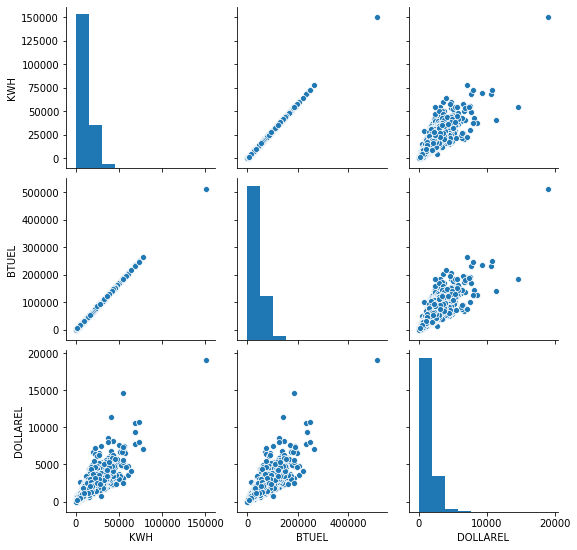

In [9]:
cols = ['KWH', 'BTUEL', 'DOLLAREL']
sns.pairplot(df_public[cols]);

### Drop unwanted columns

**Assumptions**

1) If we're trying to predict household consumption, we shouldn't be considering any information related to `KWH`, `BTUEL`, `DOLLAREL` to avoid data leakage.

2) Columns that start with 'Z' indicate whether a value has been imputed or not. This is not useful information for our model. 

For these reasons we shall drop them from our dataset. 

In [10]:
# We are keeping 'KWH' because it is our target variable
related_cols = ['BTUEL', 'DOLLAREL',  'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 
             'BTUELOTH', 'BTUELCOL', 'BTUELWTH', 'BTUELSPH', 'BTUELRFG', 
             'DOLELWTH', 'DOLELSPH', 'DOLELCOL', 'DOLELRFG', 'DOLELOTH']
# TOTALKWH, TOTALBTUEL, etc..
TOTAL_cols = list(df_public.filter(regex='^TOTAL').columns)
Z_cols = list(df_public.filter(regex='^Z').columns)

In [11]:
# Get list of all columns to drop
drop_cols = [col for col in null_cols_to_drop + related_cols + Z_cols + TOTAL_cols]

In [12]:
df_public.drop(drop_cols, axis=1, inplace=True)

In [13]:
df_public.shape

(12083, 458)

### Dependent variable

We're going to use RMSLE (root mean squared log error) as our loss function. To use this, we need to take the log of KWH. 

In [14]:
dep_var = 'KWH'
df_public[dep_var] = np.log(df_public[dep_var])

In [15]:
# Root mean squared error
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

# Calculate the rmse for a given model
def model_rmse(model, xs, y):
    return r_mse(model.predict(xs), y)

### Change string type and low cardinality columns into categorical type

Purpose: One hot encode categorical columns.

**Assumption**

I am arbitrarily counting columns with a cardinality of 4 as categorial - even though we would have to manual check which columns are really categorical, and which should be left untounched. Also the number for is arbitrary and chosen for simplicity reasons. 

We use a helper function `train_cats` which replaces a column with a numeric categorical column, if column cardinality <= max_n_cat or if the columns is object type.

In [16]:
train_cats(df_public, max_n_cat=4)

In [17]:
# Check to see which columns are now categories
df_public.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 458 columns):
 #   Column              Dtype   
---  ------              -----   
 0   DOEID               int64   
 1   REGIONC             category
 2   DIVISION            int64   
 3   REPORTABLE_DOMAIN   int64   
 4   TYPEHUQ             int64   
 5   NWEIGHT             float64 
 6   HDD65               int64   
 7   CDD65               int64   
 8   HDD30YR             int64   
 9   CDD30YR             int64   
 10  Climate_Region_Pub  int64   
 11  AIA_Zone            int64   
 12  METROMICRO          category
 13  UR                  category
 14  KOWNRENT            category
 15  YEARMADE            int64   
 16  YEARMADERANGE       int64   
 17  OCCUPYYRANGE        int64   
 18  NUMFLRS             float64 
 19  NUMAPTS             float64 
 20  WALLTYPE            int64   
 21  ROOFTYPE            float64 
 22  STUDIO              float64 
 23  NAPTFLRS            category
 24  S

Next we'll  use `proc_df` function which does the following: 
1. Replaces missing values with the median of the column, and creates a new boolean column with `[name+'_na']` suffix that is set to True for any row where the value was missing. 
2. Changes a categorical type column from text to its integer codes so that it can be used by our model.
3. One hot encodes columns with cardinality < max_n_cat
4. Splits off the response variable y.

In [18]:
df_train, y, nas = proc_df(df_public, 'KWH', max_n_cat=4)

In [19]:
# We now have more columns because proc_df did one_hot_encoding and created new _na columns
df_train.shape

(12083, 920)

## Save & Load

Since we've done a bit a processing we'll save our dataframe to not have to run all these steps again. 

In [20]:
def save_checkpoint(df, y, name):
    # Save df to feather
    df.reset_index().to_feather(f'data/processed/df_train_{name}.feather') # index must be reset in order to use feather
    
    # Save the targets to pickle
    with open('data/processed/y.pkl', 'wb') as f:
        pickle.dump(y, f)

In [21]:
def load_checkpoint(name):
    # load xs
    df_train = pd.read_feather(f'data/processed/df_train_{name}.feather')
    
    # load ys
    with open('data/processed/y.pkl', 'rb') as f:
        y = pickle.load(f)
    
    return df_train, y

In [27]:
save_checkpoint(df_train, y, 'basic_cleaning')

In [28]:
df_train, y = load_checkpoint('basic_cleaning')

## Model choice 

Let's start with a Random Forest to get a performance baseline. RF's are great because they aren't very sensitive to hyperparameter choices, rarely overfits, and are very easy to implement. 

### Train / validation split

**Assumption**: For simplicity's sake, we're assuming that we've already put asside a test set that we can use to test our model after tuning our hyperparameters. We'll only split the data into train/validation moving forward. 

We need to be very careful about how we choose our validation set. In particular, we want to design it so that it is like the test set. Since in this particular case order doesn't really matter, we can choose a random subset of our data points. 

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train, y, test_size=0.20, random_state=42)

### Random Forest


In [23]:
def rf(xs, y, 
       n_estimators=100, 
       max_samples=0.5,
       max_features=0.5, 
       min_samples_leaf=5, **kwargs):
    
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, 
                                 oob_score=True).fit(xs, y)

In [24]:
model = rf(X_train, y_train)

In [25]:
# Calculate training loss and validation loss
model_rmse(model, X_train, y_train), model_rmse(model, X_valid, y_valid)

(0.315582, 0.41694)

Let's see the impact of different values of n_estimators (number of trees). To do this, we first get the predictions from each individual tree in our forest:

In [26]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])

The following is how RMSE improves as we add more trees.

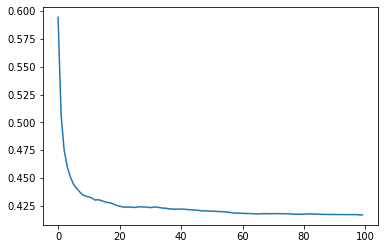

In [27]:
plt.plot([r_mse(preds[:i+1].mean(0), y_valid) for i in range(100)]);

Our model stops performing better at around 40 trees. 

### XGBoost

Next we'll train an XGBoost because they usually perform better. Let's see if this is the case for our dataset. 

In [28]:
def xgb_func(X_train, X_valid, y_train, y_valid):

    clf = xgb.XGBRegressor(learning_rate=0.01, n_estimators=2000, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0, reg_alpha=0.4,
                        reg_lambda=0.6,
                        eval_metric='rmse')

    xgb_param = clf.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgvalid = xgb.DMatrix(X_valid, label=y_valid)

    return xgb.train(xgb_param, xgtrain, evals=[(xgtrain, 'train'), (xgvalid, 'eval')], 
                     verbose_eval=200, num_boost_round=clf.get_params()['n_estimators'],
                     early_stopping_rounds=300)

In [29]:
clf = xgb_func(X_train, X_valid, y_train, y_valid)

[0]	train-rmse:8.56075	eval-rmse:8.52936
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[200]	train-rmse:1.22660	eval-rmse:1.21721
[400]	train-rmse:0.39989	eval-rmse:0.43077
[600]	train-rmse:0.34131	eval-rmse:0.39256
[800]	train-rmse:0.32136	eval-rmse:0.38577
[1000]	train-rmse:0.30558	eval-rmse:0.38171
[1200]	train-rmse:0.29191	eval-rmse:0.37967
[1400]	train-rmse:0.27982	eval-rmse:0.37809
[1600]	train-rmse:0.26877	eval-rmse:0.37705
[1800]	train-rmse:0.25833	eval-rmse:0.37643
[1999]	train-rmse:0.24883	eval-rmse:0.37588


In [30]:
clf.best_score

0.375829

Indeed, our XGBoost performed much better so this is what we'll use for interpretation moving forward.

## Model Interpretation

### Feature importance

This analysis will allows to answer our first question: 

**1. Which columns in the dataset were the most important for our predictions?**


**Feature importance next steps**

- Feature selection: We can eliminate from our model the features which had very low to no importance at all. Removing features in this way usually results in a better prediction in our model and always simlifies it. 
- Exploratory data analysis: Once we know the most important features, we can focus on understanding these features in much more depth. We should visualize their distribution, see how they are related to each other, and to the target variable, as well as other EDA methods.
- Data collection: Once we know which features best predicts something, we can focus on better collecting those variables for future observations.

**Library used: SHAP**

Out of the box feature importance methods are often unreliable and inconsistant. SHAP introduces a robust way of calculating feature importance based on Shapley values. 

SHAP's library is extremely efficient in calculating feature importance for tree-based models. This is why we are using it here. 

In [68]:
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Summary plot aka feature importance plot

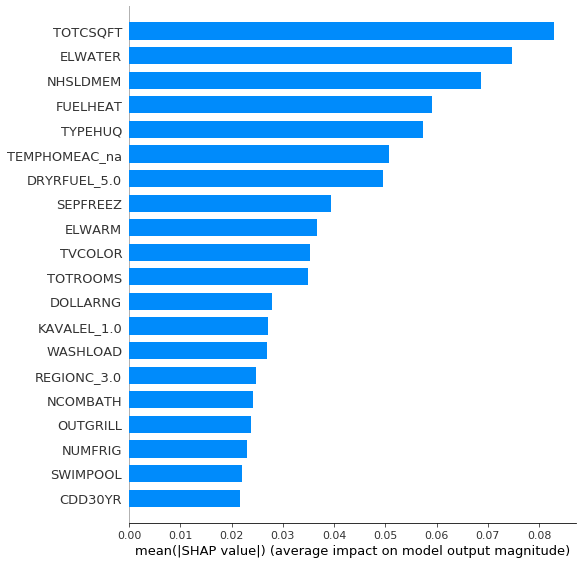

In [32]:
shap.summary_plot(shap_values, X_train, plot_type="bar", color_bar_label=None)

Now we know which are the most important features in our model: 

- TOTCSQFT   : Total cooled squared footage
- ELWATER    : Electricity used for water and heating
- NHSLDMEM   : Number of household members
- FUELHEAT   : Main space heating fuel (natural gas, propane, fuel oil, electricity, etc)
- TYPEHUQ    : Type of housing using (Mobile home, single detaches, apartment, etc)
- TEMPHOMEAC_na : Temperature when someone is home during the day - with a value of NaN
- DRYRFUEL_5.0: Fuel used by clothes dryer = Electricity
- SEPFREEZ   : Separate freezer used
- ELWARM : Electricity used for space heating


...

With this information we can now perform EDA with a priority given to these most important columns. 

## EDA

Our EDA will attempt to answer questions 2 and 3: 

**2. How are our top features related to the dependent variable?**

**3. How do they interact with each other?** 

We will use a partial dependance plot from the SHAP library to answer these questions.

### Target variable: KWZ
Before analyzing our columns, let's look at the distribution of our target variable. In the following we use a log scale to visualize the distribution.

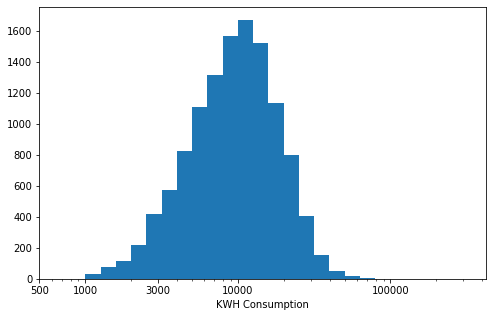

In [40]:
plt.figure(figsize=[8,5])

data = np.exp(df_public.KWH)
data_bins = 10 ** np.arange(3, np.log10(data.max())+0.4, 0.1)
plt.hist(data, bins=data_bins);
plt.xscale('log')
tick_loc = [500, 1000, 3000, 10000, 100000]
plt.xticks(tick_loc, tick_loc)
plt.xlabel('KWH Consumption');

### TOTCSQFT

Total cooled squared footage. Also visualizing this feature using log scale.

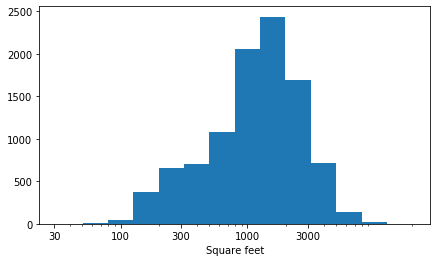

In [41]:
plt.figure(figsize=[7,4])

data = df_train.TOTCSQFT
data_bins = 10 ** np.arange(1.5, np.log10(data.max())+0.3, 0.2)
plt.hist(data, bins=data_bins);
plt.xscale('log')
tick_loc = [30, 100, 300, 1000, 3000]
plt.xticks(tick_loc, tick_loc)
plt.xlabel('Square feet');


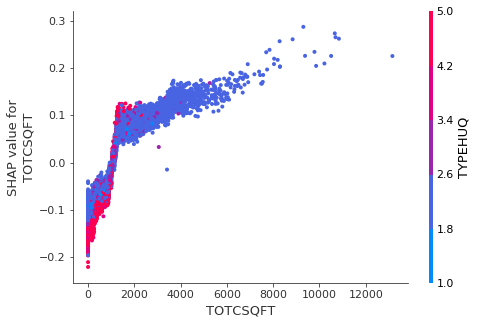

In [33]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('TOTCSQFT', shap_values, X_train, display_features=X_train, interaction_index='TYPEHUQ')

**Interpretation**: 
- There is a negative effect with `KWH` consumption below 1400 square feet, and a positive effect for values over 1750.
- There seems to be a huge jump in the consumption level at around 1500 square feet. 
- High interaction of `TOTCSQFT` with `TYPEHUQ`: Type of housing unit (low values = family home, high values = apartment building). Apartment buildings are generally consuming less. 


**Feature engineering ideas**: 
- Take the log of `TOTCSQFT`.
- Split the feature in different bins: 0-500, 500-1000, 1000-1500, 1500-2000, 2000-4000, etc

### NHSLDMEM

Number of household members

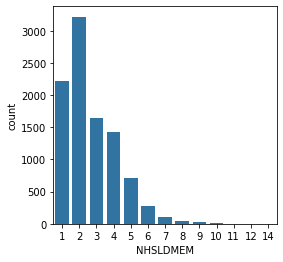

In [43]:
plt.figure(figsize=[4, 4])
base_color = sns.color_palette()[0]
sns.countplot(X_train.NHSLDMEM, color=base_color);

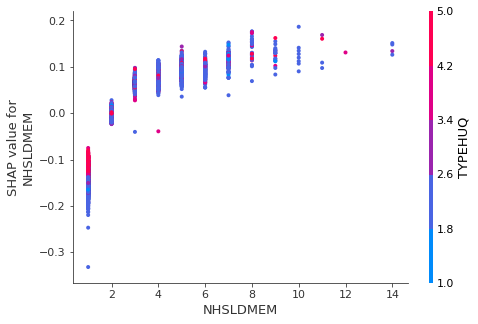

In [44]:
shap.dependence_plot('NHSLDMEM', shap_values, X_train, 
                     display_features=X_train, interaction_index='TYPEHUQ'  )

**Interpretations**: 
- Big variance in consumption for household of 1.
- Consumption significantly increases when household number > 2
- Consumption depends on the type of housing `TYPEHUQ`.

**Feature engineering idea**: 
- Create an interaction between `NHSLDMEM` and `TYPEHUQ`
- One hot encode the feature

### FUELHEAT
Main space heating fuel (natural gas, propane, fuel oil, electricity, etc)

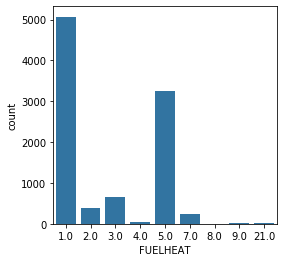

In [45]:
plt.figure(figsize=[4, 4])
base_color = sns.color_palette()[0]
sns.countplot(X_train.FUELHEAT, color=base_color)

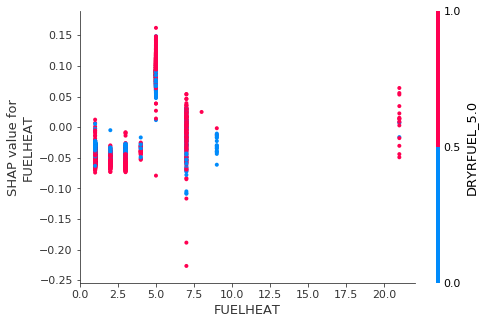

In [46]:
shap.dependence_plot('FUELHEAT', shap_values, X_train, display_features=X_train)

**Interpretations**: 
- FUELHEAT value of 5 (= 'Electricity') has the highest effect on `KWH`. 
- There is a lot of variance in consumption when FUELHEAT = 7 ('Wood'). 
- High interaction with `DRYRFUEL_5.0`. 

**Feature engineering idea**: One hot encode `FUELHEAT` in order to isolate the effect of value = 5. 

## Simplifiying our model
We're going to try dropping the features that had low or no importance according to their shap values.

In [34]:
# Take the average of absolute shap values for each feature
shap_average = [i for i in np.mean(np.absolute(shap_values), axis=0)]

In [35]:
# Pair these average shap values with the feature name 
shap_col_values = sorted([i for i in zip(shap_average, X_train.columns)], reverse=True)

In [42]:
# Get the top 90 features based on their shap values
top_features = [i[1] for i in shap_col_values][:60]

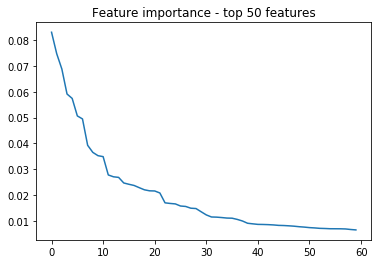

In [43]:
# Visualize feature importance based on shap values
plt.plot([i[0] for i in shap_col_values][:60]);
plt.title('Feature importance - top 50 features');

### Model performance with reduced features

In [44]:
model = rf(X_train[top_features], y_train)

In [45]:
model_rmse(model, X_train[top_features], y_train), model_rmse(model, X_valid[top_features], y_valid)

(0.328977, 0.417125)

In [46]:
clf = xgb_func(X_train[top_features], X_valid[top_features], y_train, y_valid)

[0]	train-rmse:8.56075	eval-rmse:8.52936
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[200]	train-rmse:1.22776	eval-rmse:1.21796
[400]	train-rmse:0.40645	eval-rmse:0.43160
[600]	train-rmse:0.35230	eval-rmse:0.39412
[800]	train-rmse:0.33634	eval-rmse:0.38845
[1000]	train-rmse:0.32431	eval-rmse:0.38572
[1200]	train-rmse:0.31341	eval-rmse:0.38390
[1400]	train-rmse:0.30446	eval-rmse:0.38307
[1600]	train-rmse:0.29577	eval-rmse:0.38246
[1800]	train-rmse:0.28760	eval-rmse:0.38210
[1999]	train-rmse:0.27952	eval-rmse:0.38193


In [47]:
clf.best_score

0.381866

We are getting a similar score but with a much simpler model. We removed almost 900 columns! We have now less variables to study, maintain and collect if we were to choose this subset. 

Based on these insights, let's keep this subset moving forward.

In [48]:
df_train = df_train[top_features]

In [49]:
df_train.shape

(12083, 60)

In [50]:
save_checkpoint(df_train, y, 'top_60')

### Removing redundant features

The following dendrogram will give us pairs of columns that are very similar to each other. The calculation is based on Spearman's r, which is calculating the rank correlation. 

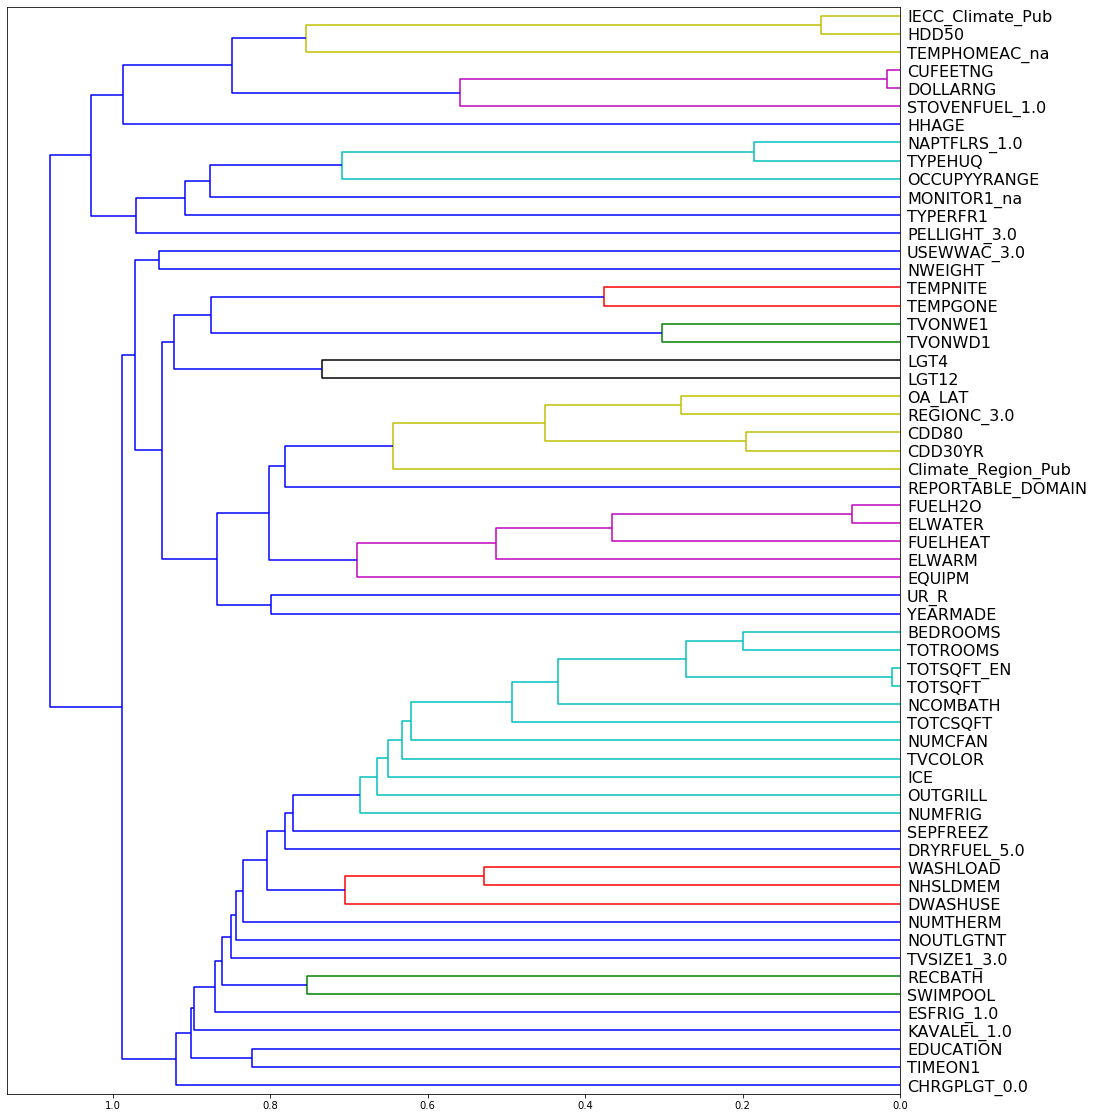

In [51]:
column_cluster(df_train)

Let's try removing some of these closely related columns to see if the model can be furthur simplified without impacting accuracy. We'll remove `CUFEETNG` and `TOTSQFT_EN`.

In [52]:
redundant_features = ['CUFEETNG', 'TOTSQFT_EN']
for feat in redundant_features:
    top_features.remove(feat)

In [53]:
len(top_features)

58

In [54]:
clf = xgb_func(X_train[top_features], X_valid[top_features], y_train, y_valid)
clf.best_score

[0]	train-rmse:8.56075	eval-rmse:8.52936
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[200]	train-rmse:1.22790	eval-rmse:1.21820
[400]	train-rmse:0.40661	eval-rmse:0.43158
[600]	train-rmse:0.35267	eval-rmse:0.39431
[800]	train-rmse:0.33686	eval-rmse:0.38879
[1000]	train-rmse:0.32497	eval-rmse:0.38607
[1200]	train-rmse:0.31409	eval-rmse:0.38433
[1400]	train-rmse:0.30492	eval-rmse:0.38354
[1600]	train-rmse:0.29633	eval-rmse:0.38295
[1800]	train-rmse:0.28806	eval-rmse:0.38262
[1999]	train-rmse:0.27997	eval-rmse:0.38235


0.382269

Score is again very similar so we'll remove them from our dataframe.

In [55]:
df_train = df_train[top_features]
save_checkpoint(df_train, y, 'top_58')

In [56]:
df_train, y = load_checkpoint('top_58')

## Feature engineering

With the new insights gained in EDA, we can perform more feature engineering.

In [57]:
# Take the log of TOTCSQFT
df_train['TOTCSQFT'] = np.log(df_public['TOTCSQFT'][df_public['TOTCSQFT']>0])

In [58]:
df_train['TOTCSQFT'].fillna(value=0)

0        8.283494
1        7.914252
2        5.575949
3        7.392032
4        0.000000
           ...   
12078    6.794587
12079    6.218600
12080    8.338306
12081    6.249975
12082    0.000000
Name: TOTCSQFT, Length: 12083, dtype: float64

In [60]:
# Interaction between dryrfuel 5 and totcsqft
df_train['TYPEHUQ__TOTCSQFT'] = df_train['TYPEHUQ'] * df_train['TOTCSQFT']

In [61]:
# One hot encode FUELHEAT - first step is to make it a category
df_train['FUELHEAT'] = df_train['FUELHEAT'].astype('category').cat.as_ordered()

In [62]:
df_train = pd.get_dummies(df_train, dummy_na=True)

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train, y, test_size=0.20, random_state=42)

In [64]:
# Retrain and see results
clf = xgb_func(X_train, X_valid, y_train, y_valid)

[0]	train-rmse:8.56076	eval-rmse:8.52924
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 300 rounds.
[200]	train-rmse:1.22776	eval-rmse:1.21586
[400]	train-rmse:0.40563	eval-rmse:0.42908
[600]	train-rmse:0.35085	eval-rmse:0.39225
[800]	train-rmse:0.33472	eval-rmse:0.38744
[1000]	train-rmse:0.32177	eval-rmse:0.38513
[1200]	train-rmse:0.31045	eval-rmse:0.38361
[1400]	train-rmse:0.30106	eval-rmse:0.38286
[1600]	train-rmse:0.29185	eval-rmse:0.38224
[1800]	train-rmse:0.28341	eval-rmse:0.38192
[1999]	train-rmse:0.27545	eval-rmse:0.38150


In [65]:
clf.best_score

0.381486

While the performance increase was not significant, this should be an iterative process.

**New feature importance after feature engineering**

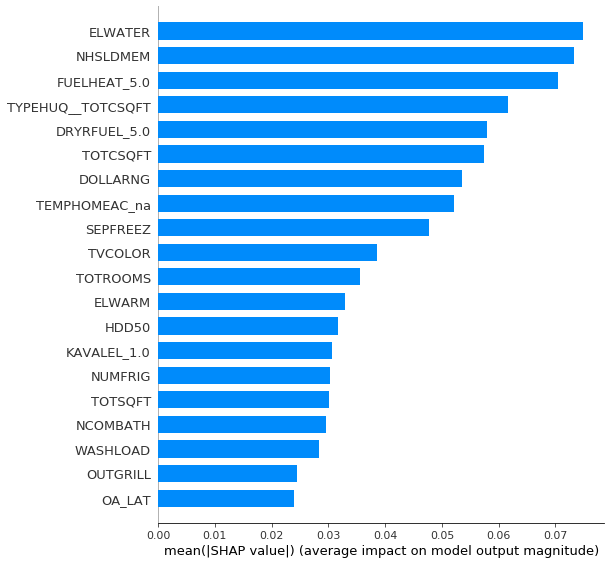

In [69]:
shap.summary_plot(shap_values, X_train, plot_type="bar", color_bar_label=None)

We are seeing different variables show up in the top most notably `FUELHEAT_5.0` as well as the interaction ` TYPEHUQ`  with `TOTCSQFR`.

## Local interpretation

We will now answer our 4th and final interpretation question:

**4. Which particular features were most important for a particular observation?**


Once our model predicts a certain energy consumption for a new observation, we'll sometimes want to understand __why__ the model made this prediction. Namely, what features contributed the most to output this decision? 

Or what if our model works as expected on an old data set, but is producing unexpected results on a new one? How would we go about interpreting this change of behavior? 

While calculating feature importance is a great way to get a sense of what has the most influence on a model, it gives little insight in understanding individual decisions on data. 

This is exactly why we'll use local interpretation. Once again SHAP library has a neat tool to do this.

In [70]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X_train.iloc[3,:])

Our prediction for this particular observation is a exp(8.62) = 5441 KWH. To understand what contributed to the prediction of 5431 KWH, we can read the force plot above. 

Top contributions that increases the consumption prediction:

- TOTSQFT = 4582
- TOTROOMS = 9
- FUEL_5.0 = Yes

Top 3 contributions that decrease the consumption prediction:

- ELWATER = 0
- EQUIPM = 2 (Steam or hot water system)
- TYPEHUQ__TOTCSQFT = NaN

## Neural Network with Fastai library

Finally we'll train a neural network using entity embeddings of categorical variables. 

> Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... it is especially useful for datasets with lots of high cardinality features, where other methods tend to overfit... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering

https://arxiv.org/abs/1604.06737

In [13]:
# Fastai library requires us to specify categorical variables and continous variables
cats, conts = [], []
for c, n in df_public.items():
    if c == 'KWH': continue
    if is_categorical_dtype(n):
        cats.append(c)
    else:
        conts.append(c)

In [14]:
len(cats), len(conts)

(153, 304)

In [15]:
# Preprocessing before inputing into our model
procs=[FillMissing, Categorify, Normalize]

In [16]:
data = (TabularList.from_df(df_public, path=PATH, cat_names=cats, cont_names=conts, procs=procs,)
                .split_by_rand_pct(valid_pct=0.2)
                .label_from_df(cols=dep_var)
                .databunch())

In [17]:
learn = tabular_learner(data, layers=[50, 30], ps=0.1,  # embedding dropout and layer dropout
                        metrics=root_mean_squared_error) 

In [18]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(6, 4)
    (2): Embedding(6, 4)
    (3): Embedding(6, 4)
    (4): Embedding(4, 3)
    (5): Embedding(3, 3)
    (6): Embedding(4, 3)
    (7): Embedding(9, 5)
    (8): Embedding(9, 5)
    (9): Embedding(9, 5)
    (10): Embedding(4, 3)
    (11): Embedding(6, 4)
    (12): Embedding(6, 4)
    (13): Embedding(6, 4)
    (14): Embedding(4, 3)
    (15): Embedding(4, 3)
    (16): Embedding(4, 3)
    (17): Embedding(4, 3)
    (18): Embedding(5, 4)
    (19): Embedding(5, 4)
    (20): Embedding(5, 4)
    (21): Embedding(5, 4)
    (22): Embedding(4, 3)
    (23): Embedding(4, 3)
    (24): Embedding(5, 4)
    (25): Embedding(4, 3)
    (26): Embedding(8, 5)
    (27): Embedding(5, 4)
    (28): Embedding(4, 3)
    (29): Embedding(8, 5)
    (30): Embedding(5, 4)
    (31): Embedding(9, 5)
    (32): Embedding(8, 5)
    (33): Embedding(6, 4)
    (34): Embedding(4, 3)
    (35): Embedding(7, 5)
    (36): Embedding(5, 4)
    (37): 

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


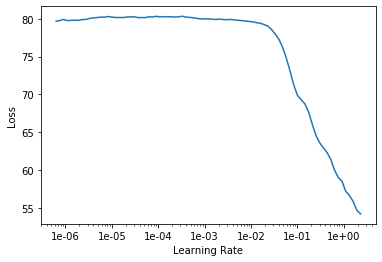

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(10, max_lr=slice(3e-2), wd=0.1) 

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,27.823845,1.652556,1.281428,00:09
1,1.769118,1.377737,0.610814,00:09
2,0.555497,0.227571,0.466557,00:09
3,0.481161,0.269079,0.508197,00:09
4,0.484354,0.333688,0.487600,00:09
5,0.463977,0.595789,0.545068,00:09
6,0.415267,0.200219,0.432153,00:09
7,0.395950,0.173231,0.401532,00:09
8,0.382531,0.188950,0.422375,00:09
9,0.369816,0.168898,0.395993,00:09


With very little effort in tuning the neural network, we are able to get a pretty decent performance. As we can see from the train_loss we're underfitting, so the model could most definitely be improved. 

From my experience we would be able to get a better performance if we turned more high cardinality variables into categories in order to benefit from entity embeddings.  

## Final Model Choice

Model | Performance | Interpretation | Ease of implementation | Score
:-- | :--: | :--: | :--: | :--: | 
Random Forest | ⭐ | ⭐⭐⭐  | ⭐⭐⭐ | 7/9
XGBoost | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ | 8/9
Neural Network | ⭐⭐ | ⭐⭐ | ⭐⭐ | 6/9

Model selection would depend on what our needs are. Based on this dataset we would choose an **XGBoost**. 


## Next steps

- More EDA to better understand our dataset
- Use insights to do more feature engineering
- Combine embeddings from neural network with other models
- Fine tune our random forest / gradient boosting models with cross validation and hyperparameter tuning: Bayesian optimization / random search

## Conclusion

After using different interpretation techniques, we now have a much better understanding of the important features of our data, what their relationships between them are, and what impact they have for any observation. 

For this dataset, the model we chose is an XGBoost.

## Sources

- [RECS Survey data](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata)
- [Fastai book](https://github.com/fastai/fastbook)
- My own blogpost - [Model interpretation with random forests and going beyong simple predictions](https://julienbeaulieu.github.io/2019/10/16/model-interpretation-with-random-forests-and-going-beyond-simple-predictions/)
